## 4. Das neuronale Netzwerk trainieren und testen

Jetzt kommen wir endlich zum Herzstück des Projekts: Das neuronale Netzwerk

Allgemeinere Dokumentation für diese Art von Maschinellem Lernen mit Scikit-learn findet sich [hier](https://scikit-learn.org/stable/modules/neural_networks_supervised.html).


Hier kommt wieder eine neue Library ins Spiel:
[`Scikit-learn`](https://de.wikipedia.org/wiki/Scikit-learn) (ehemals scikits.learn) ist eine Bibliothek zum maschinellen Lernen.


In [46]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import precision_recall_fscore_support as score
import numpy as np


mode = 1
# 1 = Nationalratswahlen
# 2 = Ständeratswahlen

filename_csv_all = "nationalrat_all.csv" if mode == 1 else "ständerat_all.csv"
filename_csv_train = "nationalrat_train.csv" if mode == 1 else "ständerat_train.csv"
filename_csv_test = "nationalrat_test.csv" if mode == 1 else "ständerat_test.csv"

Als erstes müssen die Trainingsdaten in Inputs und Labels aufgeteilt werden. Die Inputs sind in diesem Fall die Antworten zwischen 0 und 1 und die Labels sind die Parteien. Das Netzwerk soll dann lernen, in den Antworten Muster zu finden die auf die Parteien schliessen lassen.

Vielleicht haben Sie schon bemerkt, dass die Parteinamen aktuell noch Text sind. Eigentlich müssten sie deshalb noch in Zahlen umgewandelt werden. [`Scikit-learn`](https://de.wikipedia.org/wiki/Scikit-learn) macht das jedoch automatisch.

---

> **Für die Interessierten**
>
> Eine Möglichkeit wäre, jeder Partei eine Zahl zuzuweisen, also zB. `Piratenpartei=0, SP=0.1, Grüne=0.2, ...`, jedoch macht das aus mathematischer Sicht keinen Sinn, da die Parteien keine intrinsische Reihenfolge haben. Besser ist es, jeder kandidierenden Person einen Eintrag für jede Partei zu erstellen. Dieser Eintrag ist `0`, wenn die Person nicht in der Partei ist und `1`, wenn sie es ist. Da jede Person in genau einer Partei ist (zumindest nach Datensatz von Smartvote), hat jede Person genau eine Eins unter vielen Nullen, deshalb wird diese Art von Liste - auf mathematisch Vektor - One-Hot-Vector oder zu Deutsch
> [1-aus-n-Code](https://de.wikipedia.org/wiki/1-aus-n-Code) genannt, wobei n in diesem Fall für die Anzahl Parteien steht.


In [47]:
def csv_to_vector(filename):
    training_df = pd.read_csv(filename)

    input_columns = [str(q) for q in range(32214, 32289)]
    input_columns.append("gender")

    inputs = training_df[input_columns]
    labels = training_df[["partyAbbreviation"]]

    return inputs, labels


training_inputs, training_labels = csv_to_vector(filename_csv_train)
training_inputs

,32214,32215,32216,32217,32218,32219,32220,32221,32222,32223,...,32280,32281,32282,32283,32284,32285,32286,32287,32288,gender
0,0.25,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,...,0.17,0.25,0.75,0.50,0.50,0.75,0.50,0.50,0.25,0.0
1,0.75,0.25,1.00,1.00,0.00,0.00,0.75,0.00,0.25,0.75,...,0.17,0.00,1.00,0.00,0.75,0.50,0.75,0.75,0.50,0.0
2,0.25,0.75,0.75,0.25,0.75,0.25,0.75,0.25,0.25,0.75,...,0.83,0.75,0.75,0.50,0.75,0.25,0.25,0.25,0.25,0.0
3,0.00,1.00,0.25,0.00,1.00,1.00,1.00,0.75,0.25,0.25,...,1.00,1.00,0.75,0.50,0.50,0.25,0.25,0.00,0.75,1.0
4,0.25,0.00,0.75,0.75,0.25,0.00,0.00,0.00,0.25,1.00,...,0.17,0.00,0.50,1.00,0.50,0.75,0.50,1.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3653,0.00,1.00,0.25,0.25,1.00,0.75,0.25,1.00,0.25,0.25,...,0.83,0.75,0.75,0.75,0.75,0.25,0.50,0.25,0.75,0.0
3654,1.00,0.75,0.25,1.00,0.00,0.00,0.00,0.00,1.00,0.25,...,0.17,0.00,1.00,0.50,0.75,0.75,0.75,0.25,1.00,0.0
3655,0.75,0.25,1.00,1.00,0.75,0.25,0.00,0.00,0.25,0.00,...,0.83,0.50,0.50,0.25,0.50,0.50,0.50,0.75,0.50,1.0
3656,0.00,0.75,0.75,0.25,1.00,0.75,0.25,0.25,0.00,0.00,...,1.00,0.75,0.75,0.75,0.75,0.00,0.50,0.50,1.00,0.0


Jetzt kann endlich das Netzwerk trainiert werden. Wir verwenden ein [Multi-Layer-Perzeptron](https://de.wikipedia.org/wiki/Multi-Layer-Perzeptron) als Modell. Mit den `hidden_layer_sizes` muss experimentiert werden, bis die Genauigkeit zufriedenstellend ist.


In [48]:
model = MLPClassifier(
    solver="adam",
    hidden_layer_sizes=(20, 30),
    activation="relu",
    verbose=True,
    max_iter=1000,
    tol=0.000001,
)

parties = np.array(list(set(pd.read_csv(filename_csv_all)["partyAbbreviation"])))

model.classes_ = parties

model.fit(training_inputs, training_labels.to_numpy().ravel())

Iteration 1, loss = 3.29240912
Iteration 2, loss = 3.04302073
Iteration 3, loss = 2.76282031
Iteration 4, loss = 2.46203029
Iteration 5, loss = 2.17837672
Iteration 6, loss = 1.96884447
Iteration 7, loss = 1.82685484
Iteration 8, loss = 1.72119581
Iteration 9, loss = 1.63694437
Iteration 10, loss = 1.56817761
Iteration 11, loss = 1.51619052
Iteration 12, loss = 1.46767948
Iteration 13, loss = 1.42606911
Iteration 14, loss = 1.39489971
Iteration 15, loss = 1.35927465
Iteration 16, loss = 1.33303133
Iteration 17, loss = 1.30905206
Iteration 18, loss = 1.28216463
Iteration 19, loss = 1.26096430
Iteration 20, loss = 1.24194815
Iteration 21, loss = 1.22557963
Iteration 22, loss = 1.21026729
Iteration 23, loss = 1.19142028
Iteration 24, loss = 1.18342673
Iteration 25, loss = 1.17199206
Iteration 26, loss = 1.15796152
Iteration 27, loss = 1.14158263
Iteration 28, loss = 1.13154442
Iteration 29, loss = 1.12454255
Iteration 30, loss = 1.11655500
Iteration 31, loss = 1.10667735
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(20, 30), max_iter=1000, tol=1e-06,
              verbose=True)

Testen wir doch gleich noch die Genauigkeit. Es ist beim Testen wichtig, dass keine Daten verwendet werden, die das Modell beim Trainieren schon gesehen hat.


In [49]:
test_inputs, test_labels = csv_to_vector(filename_csv_test)

model.score(test_inputs, test_labels)

0.6139344262295082

~0.6 = 60%

Das heisst, dass etwa 60% der Kandidierenden zur richtigen Partei zugeordnet wurden!

Welche Parteien wurden denn Verwechselt?


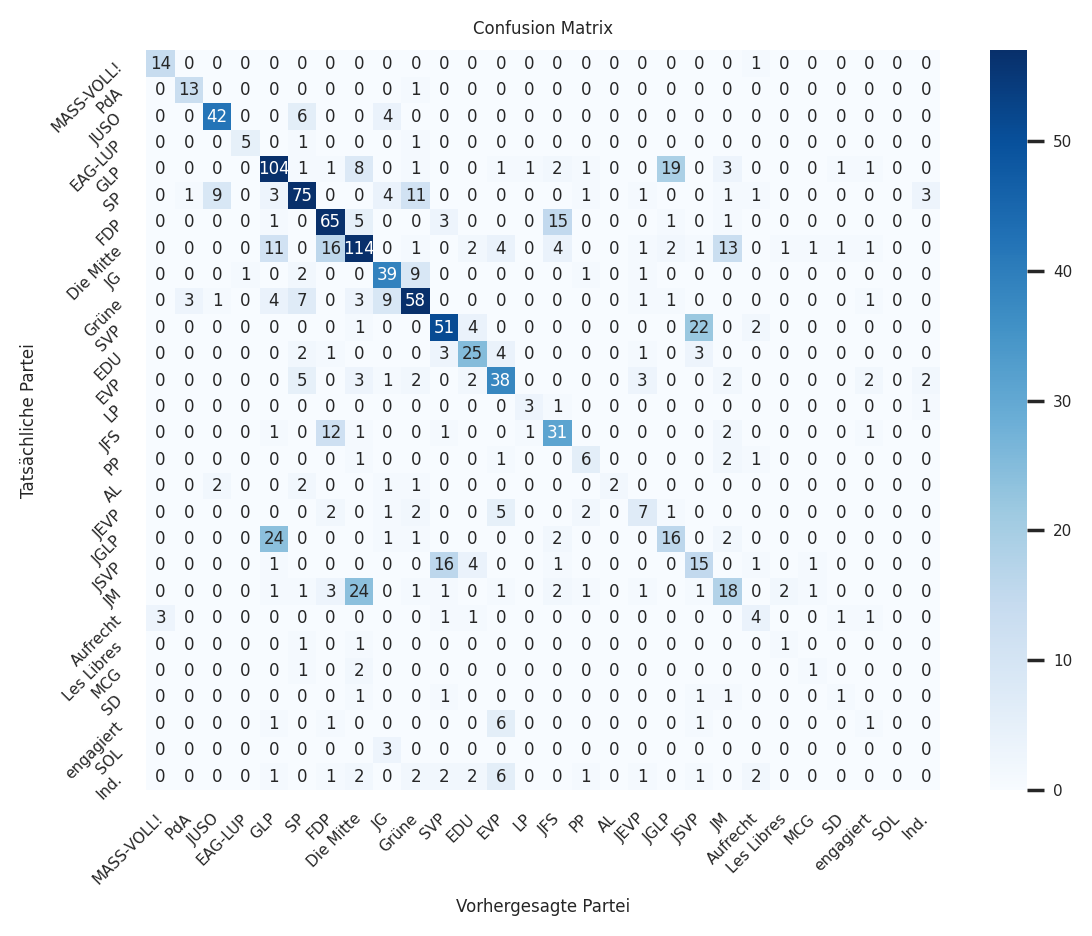

In [50]:
test_predictions = model.predict(test_inputs)

parties = [party[0] for party in sorted(zip(parties, f1_score(test_labels, test_predictions, average=None, labels=parties)), key=lambda party: party[1], reverse=True)]

cm = confusion_matrix(test_labels, test_predictions, labels=parties)


plt.figure(dpi=200)
sns.set_theme(font_scale=0.5)
ax = plt.subplot()

sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g", vmax=np.max(cm) / 2)


ax.set_xlabel("Vorhergesagte Partei")
ax.set_ylabel("Tatsächliche Partei")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(parties, rotation_mode="anchor", ha="right", va="center")
ax.yaxis.set_ticklabels(parties, rotation_mode="anchor", ha="right", va="center")

plt.show()

Die Diagonale steht für die richtig vorhergesagten Parteien, alle anderen Verfärbungen sind Verwechslungen. Man kann erkennen, dass viele Verwechslungen zwischen Parteien mit ähnlichen Agenden stattfinden. So werden Jungparteien oftmals mit ihren Mutterparteien verwechselt. Man kann auch andere spannende Dinge beobachten. So gibt es Parteien, die kaum mit anderen verwechselt werden - z.B. die SP - und es gibt solche die sehr oft mit anderen verwechselt werden - z.B. die Mitte und die Piratenpartei. Vielleicht könnten wir versuchen, das zu formalisieren.


In [51]:
def print_dict(d: dict):
    maxlen_keys = max(map(len, map(str, d.keys())))
    maxlen_values = max(map(len, map(str, d.values())))
    for key in d.keys():
        print(f"{key:.<{maxlen_keys}}{d[key]:.>{maxlen_values+1}}")


precision, recall, fscore, support = score(
    test_labels, test_predictions, labels=parties, zero_division=0
)

df = pd.DataFrame([parties, precision, recall, fscore, support]).T

df.rename(
    columns={0: "Partei", 1: "Präzision", 2: "Recall", 3: "F1-Score", 4: "Vorkommen"},
    inplace=True,
)

df = df.sort_values("F1-Score", ascending=False)

df

,Partei,Präzision,Recall,F1-Score,Vorkommen
0,MASS-VOLL!,0.823529,0.933333,0.875,15
1,PdA,0.764706,0.928571,0.83871,14
2,JUSO,0.777778,0.807692,0.792453,52
3,EAG-LUP,0.833333,0.714286,0.769231,7
4,GLP,0.684211,0.722222,0.702703,144
5,SP,0.721154,0.681818,0.700935,110
6,FDP,0.637255,0.714286,0.673575,91
7,Die Mitte,0.686747,0.65896,0.672566,173
8,JG,0.619048,0.735849,0.672414,53
9,Grüne,0.637363,0.659091,0.648045,88


Der sogenannte [F1-Score](https://databasecamp.de/statistik/f1-score) ist das harmonische Mittel von Präzision und Recall. Er stellt in diesem Fall in etwa dar, wie häufig eine Partei **nicht** verwechselt wurde. Man kann also erkennen, dass die Parteien tatsächlich sehr unterschiedlich oft richtig erkannt werden. Es scheint, also ob Parteien mit eher radikalen Agenden am häufigsten richtig erkannt werden und Jungparteien am seltensten. Die Mitte könnte so hoch auf der Rangliste sein, weil sie die meisten Kandidierenden hat, das Netzwerk also viele Beispiele gesehen hat.